In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from nltk.metrics.agreement import AnnotationTask
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.metrics import accuracy_score as accuracy
pilot_file = "Batch_3198536_batch_results.csv"

In [2]:
data = pd.read_csv(pilot_file)
data.columns = [c.replace('.', '_') for c in data.columns]
#data.head()

In [3]:
def extract_dataframe(data):
    '''
    Input: Pandas csv dataframe obtained from MTurk
    
    Output: Pandas dataframe levelled by (User x Sentenced_ID)
    '''
    data["dicts"] = data["Input_var_arrays"].map(lambda x: json.loads(x))
    global_list = []
    
    for row in data.itertuples():
        for idx, local_dict in enumerate(row.dicts):
            temp_dict = local_dict.copy()
            var_instant = "Answer_instantaneous" + str(idx+1)
            var_instant_c =  "Answer_confidence_instantaneous" + str(idx+1)
            var_start = "Answer_startpt" + str(idx+1)
            var_start_c = "Answer_confidence_startpoint" + str(idx+1)
            var_end = "Answer_endpt" + str(idx+1)
            var_end_c = "Answer_confidence_endpoint" + str(idx+1)
            var_duration = "Answer_duration" + str(idx+1)
            var_duration_c = "Answer_confidence_duration" + str(idx+1)

            temp_dict["is_instant"] = getattr(row, var_instant)
            temp_dict["conf_instant"] = getattr(row, var_instant_c)
            temp_dict["has_start"] = getattr(row, var_start)
            temp_dict["conf_start"] = getattr(row, var_start_c)
            temp_dict["has_end"] = getattr(row, var_end)
            temp_dict["conf_end"] = getattr(row, var_end_c)
            temp_dict["duration"] = getattr(row, var_duration)
            temp_dict["conf_duration"] = getattr(row, var_duration_c)
            temp_dict["worker_id"] = row.WorkerId

            global_list.append(temp_dict)
            
    return pd.DataFrame(global_list)


In [4]:
pilot_data = extract_dataframe(data)

#Re-arrange the order 
cols = list(pilot_data.columns)
pilot_data = pilot_data[pilot_data.columns[::-1]].drop('sentence', axis=1)
#pilot_data.replace('na',np.NaN, inplace=True)
pilot_data.head()

,worker_id,sentence_id,pred_token,pred,is_instant,id,has_start,has_end,duration,conf_start,conf_instant,conf_end,conf_duration
0,AQ2U4H38MELRY,en-ud-train.conllu 5784,3,occurred,True,1,na,na,na,na,2,na,na
1,AQ2U4H38MELRY,en-ud-train.conllu 5784,5,processing,False,2,true,false,7,3,2,2,2
2,AQ2U4H38MELRY,en-ud-train.conllu 1010,3,held,False,3,false,false,5,1,3,2,0
3,AQ2U4H38MELRY,en-ud-train.conllu 1010,15,curating,False,4,false,false,5,2,4,2,1
4,AQ2U4H38MELRY,en-ud-train.conllu 5106,20,acted,False,5,false,false,5,3,2,3,0


## Response distribution

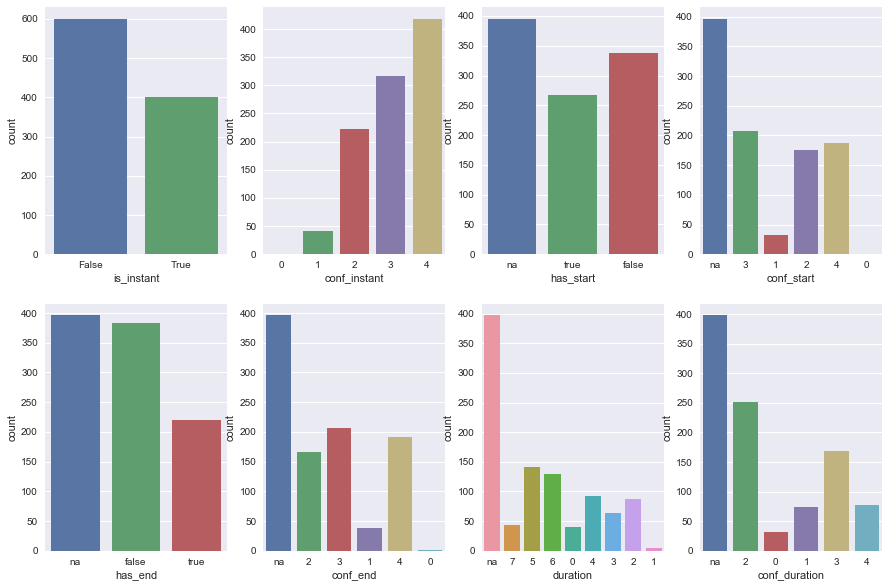

In [5]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 10))

sns.countplot(x='is_instant', data=pilot_data, ax=axs[0][0])
sns.countplot(x='conf_instant', data=pilot_data, ax=axs[0][1])
sns.countplot(x='has_start', data=pilot_data, ax=axs[0][2])
sns.countplot(x='conf_start', data=pilot_data, ax=axs[0][3])
sns.countplot(x='has_end', data=pilot_data, ax=axs[1][0])
sns.countplot(x='conf_end', data=pilot_data, ax=axs[1][1])
sns.countplot(x='duration', data=pilot_data, ax=axs[1][2])
sns.countplot(x='conf_duration', data=pilot_data, ax=axs[1][3])


plt.show()

## Inter-Annotator Agreement

In [6]:
pilot_data['sent_pred'] = pilot_data['sentence_id'].map(lambda x : x.split()[-1]) + "_" +\
                            pilot_data['pred_token'].map(lambda x: str(x))

### Raw Agreement

 #### 1. Stringent (Exact matches for a particular sent-predicate pair)

In [7]:
def calc_raw_agreement(data, key_var, check_var):
    '''
    Input: 
    1. data: Pandas dataframe
    2. key_var: variable based on which raw agreement is to be calculated
    3. check_var: vaiable on which raw agreement is calculated
    
    '''
    print("####### Raw Count for {} ###########".format(check_var))
    ids = set(list(data[key_var].values))

    total_count = len(ids)
    raw_count = 0
    keys = []
    
    for iden in ids:
        temp = list(data[data[key_var] == iden][check_var].values)
        if temp.count(temp[0]) == len(temp):
            raw_count += 1
            keys.append(iden)
     
    agreement = (raw_count/total_count)*100
    
    print("Total count of unique {} is {}".format(key_var, total_count))
    print("Raw count of matched for {} is {}".format(check_var, raw_count))
    print("Inter-annotator agreement for {} is {}%".format(check_var, agreement))
    print("\n")
    
    return agreement, keys

instant_agreement, key_inst = calc_raw_agreement(pilot_data, 'sent_pred', 'is_instant')
start_agreement, key_start = calc_raw_agreement(pilot_data, 'sent_pred', 'has_start')
end_agreement, key_end = calc_raw_agreement(pilot_data, 'sent_pred', 'has_end')

####### Raw Count for is_instant ###########
Total count of unique sent_pred is 200
Raw count of matched for is_instant is 46
Inter-annotator agreement for is_instant is 23.0%


####### Raw Count for has_start ###########
Total count of unique sent_pred is 200
Raw count of matched for has_start is 17
Inter-annotator agreement for has_start is 8.5%


####### Raw Count for has_end ###########
Total count of unique sent_pred is 200
Raw count of matched for has_end is 21
Inter-annotator agreement for has_end is 10.5%




#### 2. Average of scores(Kappa and accuracy) for each pair of annotators 

In [8]:
def extract_pairs_of_workers(data, worker_id):
    '''
    Given a pandas dataframe, and worker_id variable,
    extracts a list of pairs of worker_ids
    '''
    workers = list(set(data[worker_id].values))
    
    return list(itertools.combinations(workers, 2))

def extract_worker_sent_dict(data, worker_id, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    workers = list(set(data[worker_id].values))
    
    ans = {}
    
    for worker in workers:
        sents = set(list(data[data[worker_id] == worker][sent_id].values))
        ans[worker] = sents
        
    return ans

def average_kappa_acc(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score
    
    Output: average kappa score and average accuracy for (pairs of annotators) in the dataset

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    
    kappas = []
    accuracies = []
    
    for (w1, w2) in worker_pairs:
        
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        temp1 = []
        temp2 = []
        
        if common_set == set():
            continue
            
        for key in common_set:
            val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values

            temp1.append(val1[0])
            temp2.append(val2[0])
            
        kappas.append(kappa(temp1, temp2))
        accuracies.append(accuracy(temp1, temp2))
        
    return kappas, accuracies

In [9]:
kappas = {}
accs = {}
variables = ['is_instant', 'has_start', 'has_end', 'duration', 'conf_instant', 'conf_start', 'conf_end', 'conf_duration']
for var in variables:
    kappas[var], accs[var] = average_kappa_acc(pilot_data, 'worker_id', 'sent_pred', var)
    print("{} -- Completed!".format(var))

is_instant -- Completed!
has_start -- Completed!
has_end -- Completed!
duration -- Completed!
conf_instant -- Completed!
conf_start -- Completed!
conf_end -- Completed!
conf_duration -- Completed!


In [10]:
kappa_data = pd.DataFrame.from_dict(kappas)
acc_data = pd.DataFrame.from_dict(accs)

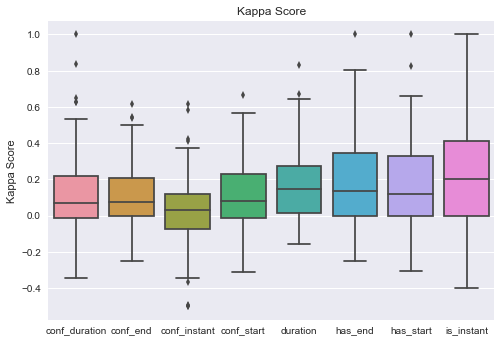

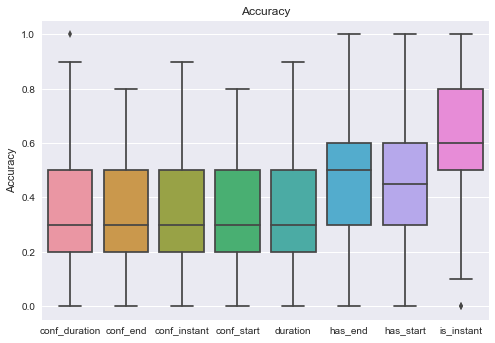

In [11]:
ax = sns.boxplot(data=kappa_data)
ax.set(ylabel='Kappa Score', title="Average Kappa Score")
plt.show()

ax = sns.boxplot(data=acc_data)
ax.set(ylabel='Accuracy', title="Average Accuracy")
plt.show()